# **Import Libraries**

**Run this cell to load in the dataset that we will use, kagglehub is an API to import datasets from kaggle**

In [ ]:
import kagglehub
gpiosenka_cards_image_datasetclassification_path = kagglehub.dataset_download('gpiosenka/cards-image-datasetclassification')
# in Google Colab, the dataset will be saved in cache
# Credit/Datasets 
# https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/data, https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [ ]:
see_versions = input("Do you wish to see the versions of libraries (y/n) ")
while not (see_versions == 'y' or see_versions == 'n'):
    print("type y or n")
    see_versions = input("Do you wish to see the versions of libraries (y/n) ")
print()


if see_versions == 'y':
  print('Python version:', sys.version)
  print('PyTorch version', torch.__version__)
  print('Torchvision version', torchvision.__version__)
  print('Numpy version', np.__version__)
  print('Pandas version', pd.__version__)

# **Preparing the Classes**

**We will need a class for the training/testing/valid datasets. This will contain information such as the length, labels, as well as information of each index inside the dataset. The Classifier will be our training model. The classifier turns each of the images into a tensor, and then operations are done onto those tensors and compared to the labels.**

In [ ]:
class PlayingCardDataset(Dataset):
  def __init__(self, curr_dataset, transform=None):
    self.data = ImageFolder(curr_dataset, transform=transform) # transform will be done later

  def __len__(self): # returns size of the dataset
    return len(self.data)

  def __getitem__(self, index): # returns instance of an item - returns a tuple (image(photo of the card), label(returns a label to the target_to_class dictionary)
    return self.data[index]

  @property
  def classes(self): # useful for plotting (will see later)
    return self.data.classes

In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # define parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) # a sequential container to hold the features

        enet_out_size = 1280 # output size of vector returned from nn.Linear

        self.classifier = nn.Sequential(
            nn.Flatten(), # flattens into a tensor
            nn.Linear(enet_out_size, num_classes) # y = xA^T + b (bias can be added as the third parameter)
        )

    def forward(self, x): # return the ouputs
        x = self.features(x)
        output = self.classifier(x)
        return output


# **Training Loop**

**This is the training loop. Run this loop for as many epochs (learning iterations) as you wish. Note that increasing the number of epochs will also lengthen the training time, but it will also give better results (assuming there is no overfitting)**

**Consider borrowing a GPU (from google colab, or some other site), as running this on your CPU will take a long time **

In [ ]:
model = SimpleCardClassifer(num_classes = 53)
# init the model

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
]) # function to resize images into tensors

# Initalize datasets

train_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
valid_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid'
test_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test'

###                       **** IMPORTANT *****
###   the paths of these directories may be different depending on your machine/IDE. Change them accordingly.
###                       **** IMPORTANT *****

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
num_epochs = 0
while not num_epochs > 0:
  try:
    num_epochs = int(input("How many epochs do you wish to train for? "))
  except ValueError:
    print("Please enter a valid integer")



In [ ]:
training_losses, valid_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Check for a GPU, ideally use google colab or another site that lets you borrow a GPU (running this on your CPU will take forever)

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
# to use another loss function, parameters such as the size of the tensor may need to be changed
# Other loss functions can be found in https://neptune.ai/blog/pytorch-loss-functions
optimizer = optim.Adam(model.parameters()) # Adam is 'Adaptive Moment Estimation', and uses root mean square propogation as well as momentum (moment of 1st/2nd derivative estimates), learning rate is init to 0.001

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'): # tqdm visualizes the progress of each loop
        images, labels = images.to(device), labels.to(device) # move to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0) # operations

    train_loss = running_loss / len(train_loader.dataset)
    training_losses.append(train_loss)

    # Validation phase, test the
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'): # tqdm visualizes the progress of each loop
            images, labels = images.to(device), labels.to(device) # move to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0) # operations

    val_loss = running_loss / len(val_loader.dataset)
    valid_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}", end = "\n")
    # show the progress of each epoch. TL and VL should both get lower with each epoch

# **Observing the results**

Show the losses using MatPlotLib. If your model is working, the loss should decrease as the number of epochs increases. The very last cell will run a script and show how accurate the model is as a whole, by randomly sampling x number of inputs and plotting the outputs

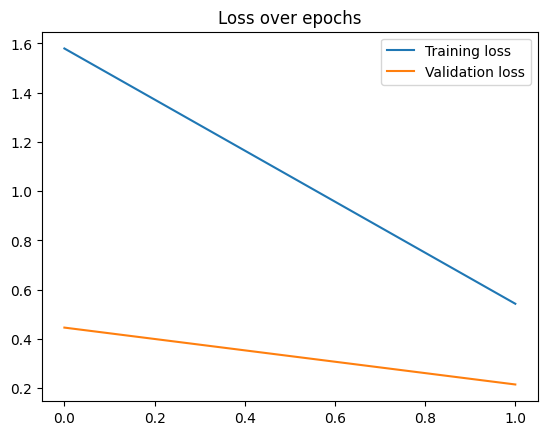

In [ ]:
plt.plot(training_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Plot will not work for only 1 epoch of training (as it would just be a dot on the y axis)

In [ ]:
from PIL import Image # useful for printing out the images later (input images)

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB") # use the python imaging library to get an rgb Image instance (to print later with matplotlib)
    return image, transform(image).unsqueeze(0) # get the image tensor

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor) # get the features
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(16, 8))

    # print image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # print predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")

    plt.tight_layout() # add some padding
    plt.show()

In [ ]:
num_examples = input("Choose how many examples you want to see: ")
while not num_examples.isdigit():
  print("Please enter a valid integer")
  num_examples = input("Choose how many examples you want to see: ")
num_examples = int(num_examples)

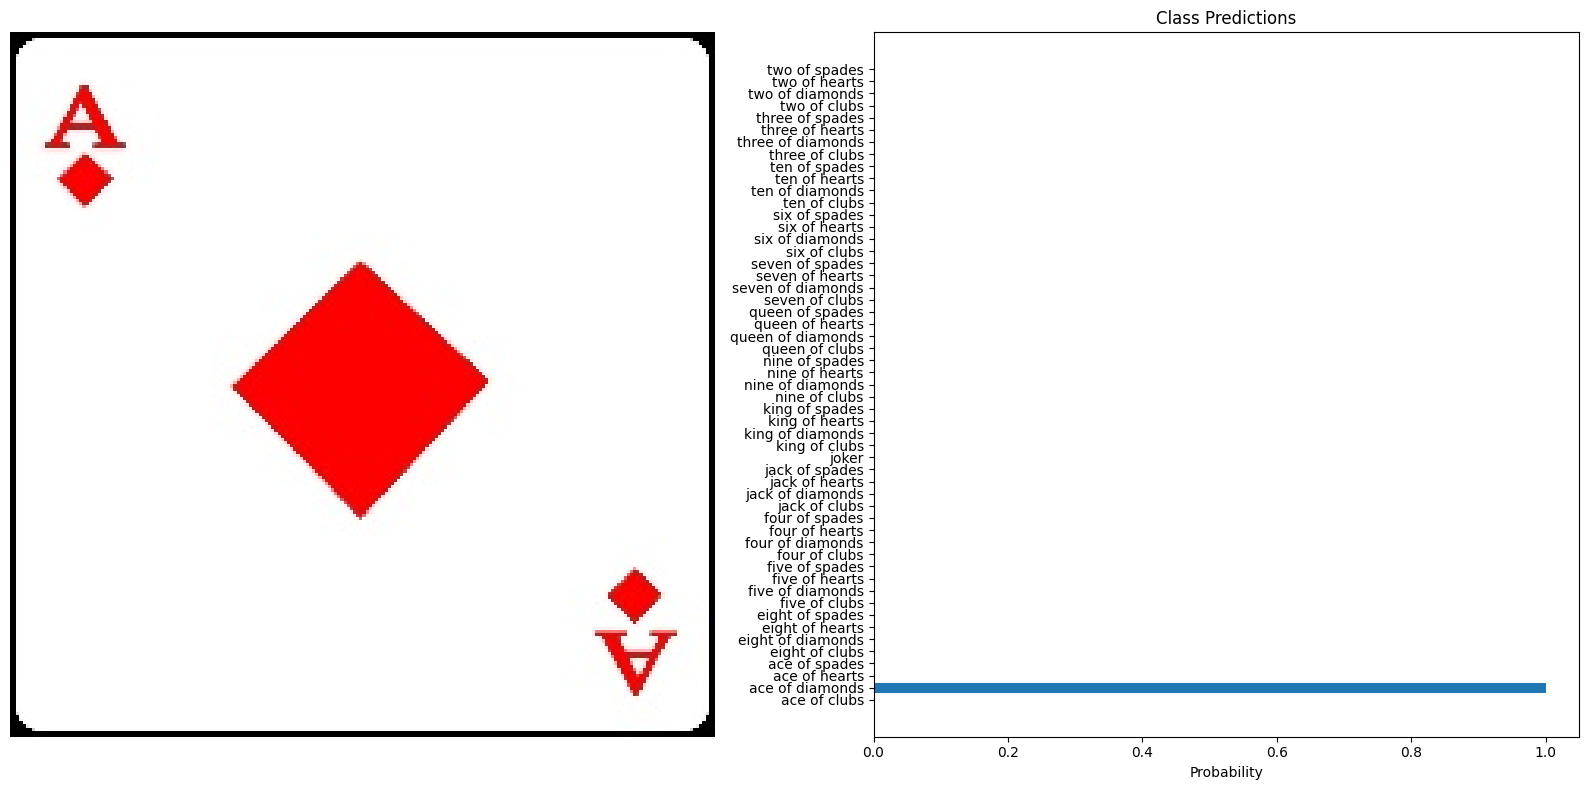

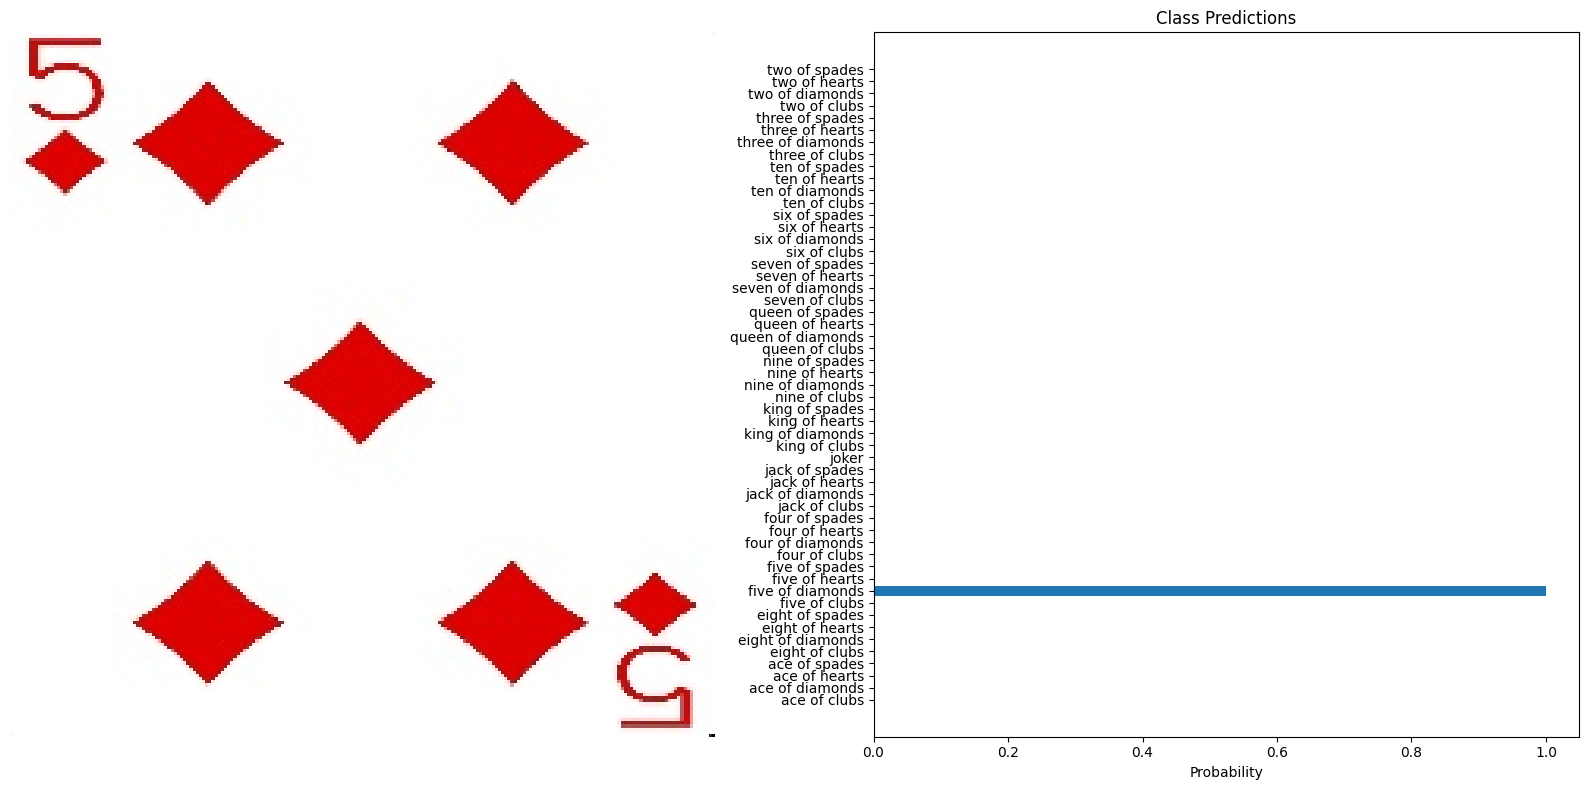

In [ ]:
from glob import glob
test_images = glob('/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test/*/*') # pass in the testing dataset
test_examples = np.random.choice(test_images, num_examples) # change second parameter to change the number of samples

for example in test_examples: # this runs for however long the second parameter is
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    class_names = val_dataset.classes
    visualize_predictions(original_image, probabilities, class_names)